### data cleaning and visualizing 

In [7]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
from tqdm import tqdm
import sklearn
!pip install segmentation_models_pytorch;
import  segmentation_models_pytorch as smp

#### train - val split 

train : 91.70873352691534% val : 8.291266473084661%


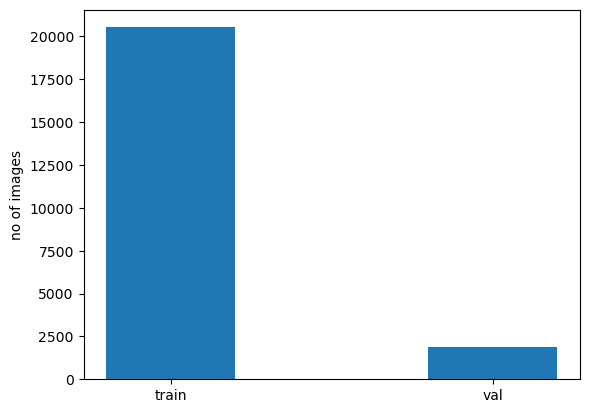

In [50]:
train_data = os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train')
val_data = os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation')
test_data = os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/test')
plt.bar(x=[2,4],height=[len(train_data),len(val_data)],orientation='vertical');
plt.ylabel('no of images');
plt.xticks([2,4],['train','val']);
print(f'train : {len(train_data)/(len(val_data)+len(train_data))*100}% val : {100-(len(train_data)/(len(val_data)+len(train_data))*100)}%')

### converting into requried fromat 
* the data contains 8 bands (8-16 bands of GOES-16 Advanced Baseline Imager (ABI)) . the ash colour format suits best in visulazing contrails
* each band has height * widith * time shape 
* where band[:,timestamp] image data corresponds to that timestamp
* masks have shape height * widith * 1 * R this mask corresponds to 4th timestamp images r dentons i'th annotator mask 
* there is another mask which is avarage of every annotator 

In [43]:
# ash colour format 
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def falseColour(band11,band14,band15):
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    return false_color
# i will be using a premade ash colour data set to  avoid this step 

### visulaizing contrails and dataset stats